In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importing the training and testing csv datasets

In [ ]:
train_df = pd.read_csv('train.csv') #full unaltered training data
test_df  = pd.read_csv('test.csv') #full unaltered test data

In [ ]:
from scipy import stats

numeric_cols = ["signal_strength", "response_level"]
z_scores = np.abs(stats.zscore(train_df[numeric_cols]))

outliers = (z_scores > 3).any(axis=1)
train_df_outliers = train_df[outliers]
train_df_clean = train_df[~outliers]

print("Outliers found:", len(train_df_outliers))


Outliers found: 0


## Data Pre-processing

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df["category"] = le.fit_transform(train_df["category"])

print(dict(zip(le.classes_, le.transform(le.classes_))))


{'Group_A': np.int64(0), 'Group_B': np.int64(1), 'Group_C': np.int64(2)}


Just a check if the data type changed or not


In [ ]:
train_df.dtypes

,0
sample_id,int64
signal_strength,float64
response_level,float64
category,int64


Just checking if the conversion was done right or not


In [ ]:
train_df.isnull().sum()

,0
sample_id,0
signal_strength,0
response_level,0
category,0


Check for duplicates again

In [ ]:
duplicates = train_df.duplicated().sum()
duplicates

np.int64(0)

## EDA

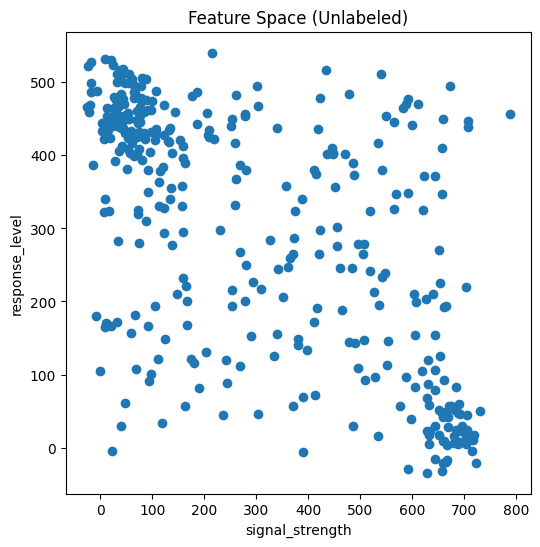

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(test_df['signal_strength'], test_df['response_level'])
plt.xlabel('signal_strength')
plt.ylabel('response_level')
plt.title('Feature Space (Unlabeled)')
plt.show()

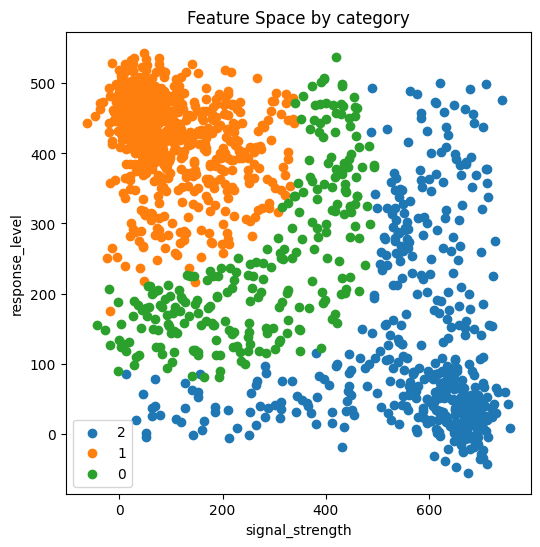

In [ ]:
plt.figure(figsize=(6,6))
for c in train_df['category'].unique():
    subset = train_df[train_df['category'] == c]
    plt.scatter(subset['signal_strength'], subset['response_level'], label=c)
plt.xlabel('signal_strength')
plt.ylabel('response_level')
plt.title('Feature Space by category')
plt.legend()
plt.show()

### Plotting a heatmap to check the correlation between the features


In [ ]:
corr = train_df.corr()
corra = train_df.corr()['category'].sort_values(ascending=False)
print(corra)

category           1.000000
signal_strength    0.575207
sample_id         -0.028770
response_level    -0.412981
Name: category, dtype: float64


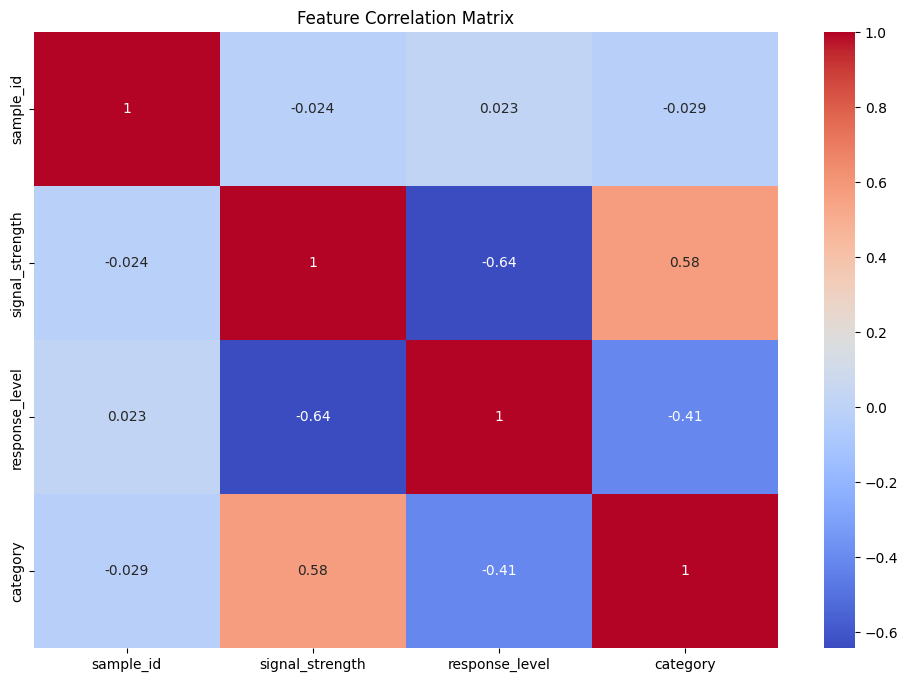

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
X_train = train_df.drop(['sample_id', 'category'], axis=1)
Y_train = train_df['category'] #true output of training data
X_test = test_df.drop(['sample_id'], axis=1)

### Standardization


we are not standardising here because if we standardise now only and feed it to train test split, there will be some data leakage.Because: during standardisation, it will be based on mean and variance of the entire training set. So even some data of the val set is leaked to the training set.
Instead standardisation will be done after train test split.

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Function to test each model

input - model, X, true Y for corresponding X

output - predicted Y, F1 score



In [ ]:
from sklearn.metrics import f1_score, mean_squared_error, r2_score

In [ ]:
from sklearn.metrics import f1_score

def evaluate_model(model, X, Y):
    # Normal prediction
    pred_labels = model.predict(X)

    # Compute macro F1 for fairness
    f1 = f1_score(Y, pred_labels, average='macro')

    return pred_labels, f1


In [ ]:
from scipy.stats import mode
def clusters_to_labels(clusters, true_y):
    clusters = np.array(clusters)
    true_y = np.array(true_y)

    labels = np.zeros_like(clusters)

    for c in np.unique(clusters):
        idx = np.where(clusters == c)[0]
        majority = mode(true_y[idx], keepdims=True)[0]
        labels[idx] = majority

    return labels

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def evaluate_clustering(model, X_train, y_train, X_val, y_val):

    # Fit on training set and get train clusters
    train_clusters = model.fit_predict(X_train)

    # Map train clusters to true labels
    train_mapped = clusters_to_labels(train_clusters, y_train)

    # Build mapping dictionary
    mapping = {c: label for c, label in zip(train_clusters, train_mapped)}

    # Predict validation clusters
    # Use predict() IF AVAILABLE (KMeans, GMM)
    if hasattr(model, "predict"):
        val_clusters = model.predict(X_val)
    else:
        # Otherwise (DBSCAN, Agglomerative) fall back to fit_predict
        val_clusters = model.fit_predict(X_val)

    # Map validation clusters to labels
    fallback_label = mode(y_train, keepdims=True)[0][0]

    mapped_preds = np.array([
        mapping.get(cluster, fallback_label)
        for cluster in val_clusters
    ])

    # Compute F1
    f1 = f1_score(y_val, mapped_preds, average="macro")

    return mapped_preds, f1


## Dividing the training set into training and validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=0, stratify=Y_train
)

scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)


#Models

## Clustering Models

### K Means

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)

pred_labels, f1_kmeans = evaluate_clustering(kmeans, X_tr_scaled, y_tr, X_val_scaled, y_val)
print("KMeans F1:", f1_kmeans)


KMeans F1: 0.8325971580208869


###GMM

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0)

pred_gmm, f1_gmm = evaluate_clustering(gmm,X_tr_scaled, y_tr, X_val_scaled, y_val)
print("GMM F1:", f1_gmm)

GMM F1: 0.694244909618405


## Classification Models

###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=300)
logreg.fit(X_tr_scaled, y_tr)

pred_logreg, f1_logreg = evaluate_model(logreg, X_val_scaled, y_val)
print("Logistic Regression F1:", f1_logreg)

Logistic Regression F1: 0.8678484231494702


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg2 = LogisticRegression(
    max_iter=300,
    C=0.1,
    solver='lbfgs',
    class_weight='balanced'
)

logreg2.fit(X_tr_scaled, y_tr)
pred_logreg2, f1_logreg2 = evaluate_model(logreg2, X_val_scaled, y_val)
print("Logistic Regression F1:", f1_logreg2)


Logistic Regression F1: 0.8813791720413113


###SVM

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', probability=False, random_state=0)
svm_model.fit(X_tr_scaled, y_tr)

pred_svm, f1_svm = evaluate_model(svm_model, X_val_scaled, y_val)
print("SVM F1:", f1_svm)


SVM F1: 0.9899918300653595


In [ ]:
from sklearn.svm import SVC

svm2 = SVC(
    kernel='rbf',
    C=15,
    gamma='scale',
    class_weight='balanced',
    probability=False,

)
svm2.fit(X_tr_scaled, y_tr)

pred_svm, f1_svm = evaluate_model(svm2, X_val_scaled, y_val)
print("SVM F1:", f1_svm)


SVM F1: 1.0


In [ ]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

param_grid = {
    "kernel": ["linear", "rbf"],
    "C": np.linspace(1, 10, 100),
    "gamma": ["scale", "auto"]
}

svm_cv = GridSearchCV(
    SVC(class_weight='balanced',
        probability = True),
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=-1
)

svm_cv.fit(X_tr_scaled, y_tr)
print("Best params:", svm_cv.best_params_)
best_svm = svm_cv.best_estimator_
pred_svm, f1_svm = evaluate_model(best_svm, X_val_scaled, y_val)
print("SVM F1:", f1_svm)


Best params: {'C': np.float64(9.90909090909091), 'gamma': 'scale', 'kernel': 'rbf'}
SVM F1: 0.9950185533472272


###Neural Networks

In [ ]:
from sklearn.neural_network import MLPClassifier

nn1 = MLPClassifier(
    hidden_layer_sizes=(64,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate_init=0.001,
    max_iter=500,
    random_state=0
)

nn1.fit(X_tr_scaled, y_tr)
pred_nn1, f1_nn1 = evaluate_model(nn1, X_val_scaled, y_val)
print("Neural Network F1:", f1_nn1)

Neural Network F1: 0.9854571970354931


In [ ]:
from sklearn.neural_network import MLPClassifier

nn2 = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=0
)
nn2.fit(X_tr_scaled, y_tr)

MLPClassifier(alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(128, 64, 32), max_iter=1000,
              n_iter_no_change=20, random_state=0)

In [ ]:
pred_nn2, f1_nn2 = evaluate_model(nn2, X_val_scaled, y_val)
print("F1:", f1_nn2)

F1: 0.9746179746179746


In [ ]:
# param_grid = {
#     'hidden_layer_sizes': [(64,),(128,64)],
#     'activation': ['relu'],
#     'solver': ['adam'],
#     'alpha': [0.0001, 0.001, 0.01],   # L2 regularization
#     'learning_rate_init': [0.001, 0.01]
# }
# mlp = MLPClassifier(max_iter=150,
#     early_stopping=True,
#     n_iter_no_change=10,)

# grid1 = GridSearchCV(
#     estimator=mlp,
#     param_grid=param_grid,
#     scoring='f1',
#     cv=3,
#     n_jobs=-1
# )

# grid1.fit(X_tr, y_tr)

# print("Best Neural Network Params:", grid1.best_params_)

# best_nn = grid1.best_estimator_

# pred_nn, f1_nn = evaluate_model(best_nn, X_val, y_val)

# print("Validation F1 (Neural Net):", f1_nn)


#### pytorch

Define a custom PyTorch-based MLP classifier:
 - __init__ sets model hyperparameters (hidden size, layers, dropout, lr, etc.).
- _build_model builds a feedforward network with ReLU and Dropout.
- fit trains the model using Adam optimizer and CrossEntropyLoss on one-hot encoded labels.
- predict returns class indices from the trained network.
- score computes accuracy by comparing predictions with true labels.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class TorchMLPClassifier:
    def __init__(self, hidden_dim=64, hidden_layers=2, dropout=0.2, lr=1e-3, batch_size=64, epochs=20):
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs

    def _build_model(self, input_dim, output_dim):
        layers = []
        in_dim = input_dim
        for _ in range(self.hidden_layers):
            layers += [nn.Linear(in_dim, self.hidden_dim), nn.ReLU(), nn.Dropout(self.dropout)]
            in_dim = self.hidden_dim
        layers += [nn.Linear(in_dim, output_dim)]
        return nn.Sequential(*layers)

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = pd.get_dummies(y).values.astype(np.float32)  # one-hot
        dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        input_dim = X.shape[1]
        output_dim = y.shape[1]
        self.model = self._build_model(input_dim, output_dim)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(self.epochs):
            for xb, yb in loader:
                optimizer.zero_grad()
                logits = self.model(xb)
                loss = criterion(logits, torch.argmax(yb, dim=1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        with torch.no_grad():
            logits = self.model(torch.from_numpy(X))
            preds = torch.argmax(logits, dim=1).numpy()
        return preds

    def score(self, X, y):
        preds = self.predict(X)
        return (preds == pd.Categorical(y).codes).mean()

Wrap the custom PyTorch MLP inside a scikit-learn compatible class (TorchWrapper).
LabelEncoder ensures string labels are converted to integers for training and back to strings for predictions.
Build a pipeline with preprocessing + TorchWrapper, then tune hyperparameters using GridSearchCV.
Finally, evaluate the best PyTorch MLP model on the validation set.


In [ ]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class TorchWrapper(BaseEstimator):
    def __init__(self, hidden_dim=64, hidden_layers=2, dropout=0.2,
                 lr=1e-3, batch_size=64, epochs=20):
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.clf = TorchMLPClassifier(hidden_dim, hidden_layers,
                                      dropout, lr, batch_size, epochs)
        self.le_ = None  # label encoder

    def fit(self, X, y):
        # Encode string labels to integers
        self.le_ = LabelEncoder()
        y_enc = self.le_.fit_transform(y)
        self.clf.fit(X, y_enc)
        return self

    def predict(self, X):
        preds = self.clf.predict(X)
        # Map back to original string labels
        return self.le_.inverse_transform(preds)

    def score(self, X, y):
        y_enc = self.le_.transform(y)
        preds = self.clf.predict(X)
        return (preds == y_enc).mean()

torch_pipe = Pipeline([
    ("clf", TorchWrapper())
])

torch_param_grid = {
    "clf__hidden_dim": [64, 128],
    "clf__hidden_layers": [1, 2],
    "clf__dropout": [0.1, 0.3],
    "clf__lr": [1e-3, 3e-4],
    "clf__epochs": [20, 40]
}

torch_cv = GridSearchCV(
    torch_pipe,
    param_grid=torch_param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=1
)


torch_cv.fit(X_tr_scaled, y_tr)
print("Best params:", torch_cv.best_params_)
best_torch = torch_cv.best_estimator_
pred_torch, f1_torch = evaluate_model(best_torch, X_val_scaled, y_val)
print("torch F1:", f1_torch)



Best params: {'clf__dropout': 0.1, 'clf__epochs': 40, 'clf__hidden_dim': 64, 'clf__hidden_layers': 2, 'clf__lr': 0.0003}
torch F1: 0.9664444733947078


#Model Comparision

In [ ]:
results = [
    ("K means", f1_kmeans),
    ("GMM", f1_gmm),
    ("Logistic Regression", f1_logreg2),
    ("SVM", f1_svm),
    ("Neural Networks", f1_nn1),
]

results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
model_names = [x[0] for x in results_sorted]

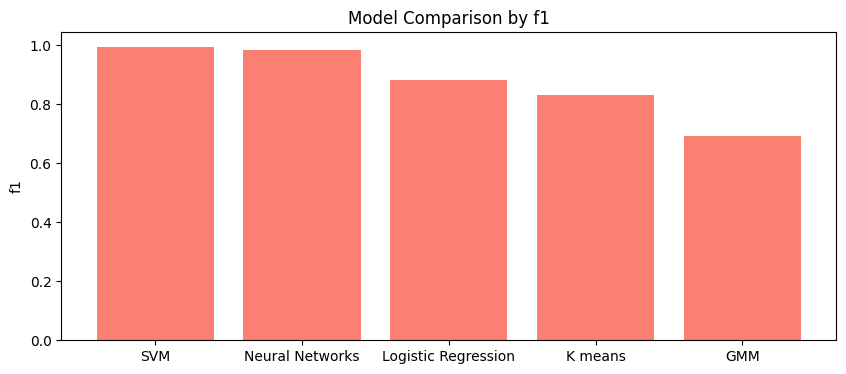

In [ ]:
f1_scores = [x[1] for x in results_sorted]

plt.figure(figsize=(10,4))
plt.bar(model_names, f1_scores, color='salmon')
plt.ylabel('f1')
plt.title('Model Comparison by f1')
plt.show()

We can see that SVM works the best

# Submission Files Generation

This part is used to generate submission files in the required format, using the models trained earlier above

In [ ]:
X_test_scaled = scaler.transform(X_test)

In [ ]:
#X_t = poly.transform(X_test_scaled)
preds = svm_model.predict(X_test_scaled)

In [ ]:
decoded_preds = le.inverse_transform(preds)

In [ ]:
# pred_prob = nn.predict_proba(X_test_scaled)[:, 1]

# preds = (pred_prob >= 0.36).astype(int)


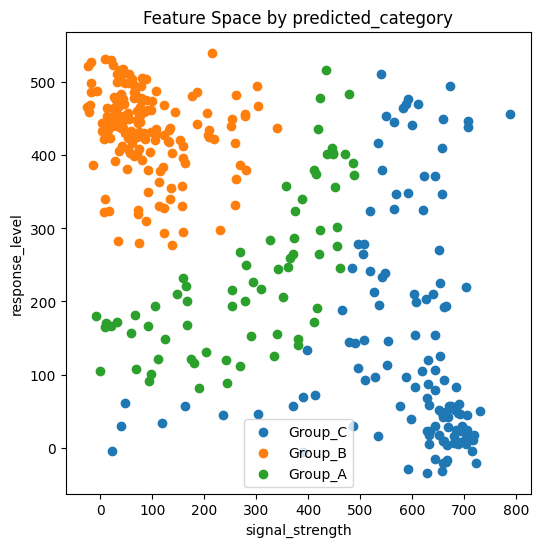

In [ ]:
test_df_plot = test_df.copy()
test_df_plot["predicted_category"] = decoded_preds
plt.figure(figsize=(6,6))
for c in test_df_plot['predicted_category'].unique():
    subset = test_df_plot[test_df_plot['predicted_category'] == c]
    plt.scatter(subset['signal_strength'], subset['response_level'], label=c)
plt.xlabel('signal_strength')
plt.ylabel('response_level')
plt.title('Feature Space by predicted_category')
plt.legend()
plt.show()

In [ ]:
submission = pd.DataFrame({
    "sample_id": test_df["sample_id"],
   "category": decoded_preds
})
submission

,sample_id,category
0,1369,Group_C
1,66,Group_C
2,701,Group_B
3,939,Group_A
4,1622,Group_C
...,...,...
357,1694,Group_A
358,417,Group_B
359,1037,Group_C
360,1318,Group_C


In [ ]:
submission.to_csv('submission_svm.csv', index=False)